<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [515]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import patsy
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.feature_selection import RFECV

from sklearn.linear_model import LassoCV, LogisticRegressionCV, LogisticRegression, ElasticNetCV, SGDRegressor, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import TomekLinks

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, recall_score, precision_score

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [516]:
# set a common random state & njobs
rs = 3
njobs= 4

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [315]:
# Load the data
house = pd.read_csv('./housing.csv')

# show all columns
pd.set_option('max_columns', 100)
pd.set_option('max_rows', 100)

In [316]:
# A:
print house.shape
house.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [317]:
# check for duplicates - there are none. good.
house.duplicated().sum()

0

In [318]:
print house['Id'].nunique()
# drop the Id column as it does not provide any addtional info
house.drop('Id', axis=1, inplace=True)
print house.shape
house.head()

1460
(1460, 80)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [319]:
house.describe()
# all the variables appear to be within expected range, 
# no negative sq feet, months and years are in order

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [320]:
house.describe(include=['O'])
# there are a lot of categorical variables that are actually ordinal - should correct them

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1452,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,4,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,864,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,380,870,605,1311,1326,1340,3,157,49,1267,1198


In [321]:
house.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating           object
HeatingQC         object


In [322]:
print house.MSZoning.value_counts()
# there are 10 commercial plots

# drop the commercial plots
house = house[house['MSZoning']!='C (all)']
print house.MSZoning.value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64
RL    1151
RM     218
FV      65
RH      16
Name: MSZoning, dtype: int64


### Deal with missing values

In [323]:
# check for percentage of null values, show top 10 with highest percentage missing
print (house.isnull().sum() / float(house.shape[0])).sort_values(ascending=False).head(10)

# there are 5 variables with null values > 20%... 
# even if we try to impute values, it won't be accurate

# decide to drop them
house.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)
print house.shape # check that new no of cols is correct - yes

PoolQC          0.995172
MiscFeature     0.964138
Alley           0.938621
Fence           0.808276
FireplaceQu     0.469655
LotFrontage     0.178621
GarageType      0.054483
GarageCond      0.054483
GarageFinish    0.054483
GarageQual      0.054483
dtype: float64
(1450, 75)


In [324]:
# inspect the rest of the features with missing values
print (house.isnull().sum() / float(house.shape[0])).sort_values(ascending=False).head(15)

LotFrontage     0.178621
GarageType      0.054483
GarageYrBlt     0.054483
GarageCond      0.054483
GarageQual      0.054483
GarageFinish    0.054483
BsmtExposure    0.026207
BsmtFinType2    0.026207
BsmtFinType1    0.025517
BsmtCond        0.025517
BsmtQual        0.025517
MasVnrArea      0.005517
MasVnrType      0.005517
Electrical      0.000690
Exterior1st     0.000000
dtype: float64


70.0528967254 70.0


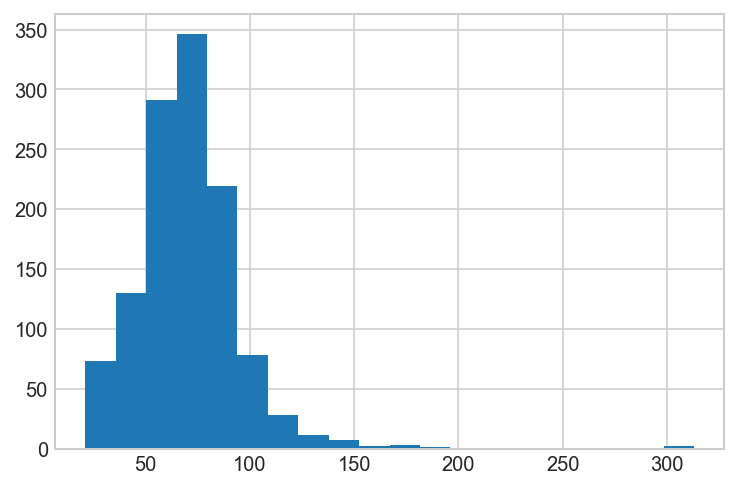

In [325]:
# for the rest of the features with null values, figure out what to do...

# LotFrontage: linear feet of street connected to property
house.LotFrontage.hist(bins=20)
print house.LotFrontage.mean(), house.LotFrontage.median()
# since mean and median are quite close, skew doesn't look so bad on plot, input null with median.
house.LotFrontage.fillna(house.LotFrontage.median(), inplace=True)

In [326]:
# GarageYrBlt: Year garage was built
# GarageType: Garage location, NA = no garage
# GarageQual: Garage Quality, NA = no garage
# GarageCond: Garage Condition, NA = no garage
# GarageFinish:Interior finish of the garage, NA = no garage

# consider them together since they are all about the garage and have the same percentage of nulls
house[house.GarageType.isnull()][['GarageYrBlt', 'GarageType', 'GarageCond', 'GarageQual', 'GarageFinish']]

,GarageYrBlt,GarageType,GarageCond,GarageQual,GarageFinish
39,NaN,NaN,NaN,NaN,NaN
48,NaN,NaN,NaN,NaN,NaN
78,NaN,NaN,NaN,NaN,NaN
89,NaN,NaN,NaN,NaN,NaN
99,NaN,NaN,NaN,NaN,NaN
108,NaN,NaN,NaN,NaN,NaN
125,NaN,NaN,NaN,NaN,NaN
127,NaN,NaN,NaN,NaN,NaN
140,NaN,NaN,NaN,NaN,NaN
148,NaN,NaN,NaN,NaN,NaN


In [327]:
# the null values are because those houses have no garage
# replace nulls in GarageType & GarageFinish with 'NA'
house.GarageType.fillna('NA', inplace=True)
house.GarageQual.fillna('NA', inplace=True)
house.GarageCond.fillna('NA', inplace=True)
house.GarageFinish.fillna('NA', inplace=True)

# replace GarageYrBlt with 0 - flag
house.GarageYrBlt.fillna(0, inplace=True)

#check
house[house.GarageType=='NA'][['GarageYrBlt', 'GarageType', 'GarageCond', 'GarageQual', 'GarageFinish']]

,GarageYrBlt,GarageType,GarageCond,GarageQual,GarageFinish
39,0.0,NA,NA,NA,NA
48,0.0,NA,NA,NA,NA
78,0.0,NA,NA,NA,NA
89,0.0,NA,NA,NA,NA
99,0.0,NA,NA,NA,NA
108,0.0,NA,NA,NA,NA
125,0.0,NA,NA,NA,NA
127,0.0,NA,NA,NA,NA
140,0.0,NA,NA,NA,NA
148,0.0,NA,NA,NA,NA


In [328]:
# BsmtExposure: Refers to walkout or garden level walls
# BsmtFinType1: Rating of basement finished area
# BsmtFinType2: Rating of basement finished area (if multiple types)
# BsmtCond: Evaluates the general condition of the basement
# BsmtQual: Evaluates the height of the basement
# For all these, NA = no basement. 

# strangely the percentage of null values is not the same for all the Bsmt related variables...
# decide to inspect all the features related to Bsmt
house[house.BsmtExposure.isnull()][[col for col in house.columns if 'Bsmt' in col]]


,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
17,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
39,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
90,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
102,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
156,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
182,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
259,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
342,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
362,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
371,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0


In [329]:
# there is 1 house that cannot decide if it has a basement or not... drop that row.
house.drop(948, axis=0, inplace=True)
print house.shape
house[house.BsmtExposure.isnull()][[col for col in house.columns if 'Bsmt' in col]]

(1449, 75)


,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
17,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
39,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
90,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
102,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
156,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
182,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
259,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
342,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
362,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
371,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0


In [330]:
# since all the basement variables are categorical, replace null values with 'NA'
house.BsmtExposure.fillna('NA', inplace=True)
house.BsmtFinType2.fillna('NA', inplace=True)
house.BsmtFinType1.fillna('NA', inplace=True)
house.BsmtCond.fillna('NA', inplace=True)
house.BsmtQual.fillna('NA', inplace=True)

In [331]:
# MasVnrType: Masonry veneer type, none= no veneer
# MasVnrArea: Masonry veneer area in square feet
# same number of nulls, linked
house[house.MasVnrType.isnull()][['MasVnrType', 'MasVnrArea']]
# replace nulls in MasVnrArea with 0, MasVnrType with 'NA'
house.MasVnrType.fillna('NA', inplace=True)
house.MasVnrArea.fillna(0, inplace=True)
# check
house[house.MasVnrType=='NA'][['MasVnrType', 'MasVnrArea']]

,MasVnrType,MasVnrArea
234,NA,0.0
529,NA,0.0
650,NA,0.0
936,NA,0.0
973,NA,0.0
977,NA,0.0
1243,NA,0.0
1278,NA,0.0


In [332]:
# Electrical: Electrical system - categorical. 
# since from the utilities feature we see that all homes have electricity, replace with mode.
house.Electrical.fillna(house.Electrical.mode()[0], inplace=True)

In [333]:
# check that there are now no more null values
house.isnull().sum().sort_values(ascending=False).head()

SalePrice       0
YearRemodAdd    0
RoofMatl        0
Exterior1st     0
Exterior2nd     0
dtype: int64

### Convert datatypes

In [334]:
# now let's deal with the datatypes that are weird
house.describe(include=['O'])

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
count,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449
unique,4,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,5,4,5,6,5,5,5,7,7,6,5,2,5,4,7,7,4,6,6,3,9,6
top,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Attchd,Unf,TA,TA,Y,WD,Normal
freq,1150,1445,916,1304,1448,1043,1374,225,1251,1435,1210,722,1134,1423,514,503,854,899,1274,646,639,1302,947,423,1245,1418,739,1360,1328,727,1349,869,600,1302,1318,1334,1260,1193


In [335]:
# from description, MSSubClass should be a categorical variable
house.MSSubClass= house.MSSubClass.astype(str)
house.MSSubClass.dtype

# convert all the features with rankings to ordinal:
rank_f1 = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', \
          'KitchenQual', 'GarageQual', 'GarageCond']
grademap1 = {'Ex': 5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0}
for f in rank_f1:
    house[f] = house[f].map(grademap1)

# convert all the features with rankings to ordinal:
rank_f2 = ['BsmtFinType1', 'BsmtFinType2']
grademap2 = {'GLQ': 6, 'ALQ':5, 'BLQ': 4, 'Rec':3, 'LwQ':2, 'Unf':1, 'NA':0}
for f in rank_f2:
    house[f] = house[f].map(grademap2)

# code BsmtExposure into ordinal variable
grademap3 = {'Gd':4, 'Av':3, 'Mn':2, 'No':1, 'NA':0}
house['BsmtExposure']= house['BsmtExposure'].map(grademap3)

# code functionality into ordinal variable
grademap4 = {'Typ':8, 'Min1':7, 'Min2':6, 'Mod':5, 'Maj1':4, 'Maj2':3, 'Sev':2, 'Sal':1}
house['Functional']= house['Functional'].map(grademap4)

# convert CentralAir Y/N features to binary
binary_f = ['CentralAir']
binarymap = {'N':0, 'Y':1}
house['CentralAir']= house['CentralAir'].map(binarymap)

house.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,4,3,PConc,4,3,1,6,706,1,0,150,856,GasA,5,1,SBrkr,856,854,0,1710,1,0,2,1,3,1,4,8,8,0,Attchd,2003.0,RFn,2,548,3,3,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,3,CBlock,4,3,4,5,978,1,0,284,1262,GasA,5,1,SBrkr,1262,0,0,1262,0,1,2,0,3,1,3,6,8,1,Attchd,1976.0,RFn,2,460,3,3,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,4,3,PConc,4,3,2,6,486,1,0,434,920,GasA,5,1,SBrkr,920,866,0,1786,1,0,2,1,3,1,4,6,8,1,Attchd,2001.0,RFn,2,608,3,3,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,3,3,BrkTil,3,4,1,5,216,1,0,540,756,GasA,4,1,SBrkr,961,756,0,1717,1,0,1,0,3,1,4,7,8,1,Detchd,1998.0,Unf,3,642,3,3,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,4,3,PConc,4,3,3,6,655,1,0,490,1145,GasA,5,1,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,4,9,8,1,Attchd,2000.0,RFn,3,836,3,3,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000


In [336]:
# visually check the remaining categorical variables - looks ok
house.describe(include=['O'])

,MSSubClass,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,Electrical,GarageType,GarageFinish,PavedDrive,SaleType,SaleCondition
count,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449
unique,15,4,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,5,6,6,5,7,4,3,9,6
top,20,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,PConc,GasA,SBrkr,Attchd,Unf,Y,WD,Normal
freq,534,1150,1445,916,1304,1448,1043,1374,225,1251,1435,1210,722,1134,1423,514,503,854,646,1418,1328,869,600,1334,1260,1193


### Feature Engineering

In [337]:
# look at all the year variables
house[['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']]

# perhaps the house age at point of sale would better predict the sale price
house['AgeSold'] = house['YrSold'] - house['YearBuilt']
house['AgeRemod'] = house['YrSold'] - house['YearRemodAdd']
house['GarageAge'] = house['YrSold'] - house['GarageYrBlt'].astype(int)

# since we previously set 0 for the NA flag for GarageYrBlt, find those values, set to zero
house['GarageAge'] = [0 if age > 1000 else age for age in house['GarageAge']]

house.drop(['YearBuilt', 'YearRemodAdd', 'GarageYrBlt'], axis=1, inplace=True)
house.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,AgeSold,AgeRemod,GarageAge
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,4,3,PConc,4,3,1,6,706,1,0,150,856,GasA,5,1,SBrkr,856,854,0,1710,1,0,2,1,3,1,4,8,8,0,Attchd,RFn,2,548,3,3,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500,5,5,5
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,3,CBlock,4,3,4,5,978,1,0,284,1262,GasA,5,1,SBrkr,1262,0,0,1262,0,1,2,0,3,1,3,6,8,1,Attchd,RFn,2,460,3,3,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500,31,31,31
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,4,3,PConc,4,3,2,6,486,1,0,434,920,GasA,5,1,SBrkr,920,866,0,1786,1,0,2,1,3,1,4,6,8,1,Attchd,RFn,2,608,3,3,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500,7,6,7
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,3,3,BrkTil,3,4,1,5,216,1,0,540,756,GasA,4,1,SBrkr,961,756,0,1717,1,0,1,0,3,1,4,7,8,1,Detchd,Unf,3,642,3,3,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000,91,36,8
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,4,3,PConc,4,3,3,6,655,1,0,490,1145,GasA,5,1,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,4,9,8,1,Attchd,RFn,3,836,3,3,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000,8,8,8


In [338]:
# from data description, Condition1 and Condition2 are the same
house[['Condition1', 'Condition2']]

,Condition1,Condition2
0,Norm,Norm
1,Feedr,Norm
2,Norm,Norm
3,Norm,Norm
4,Norm,Norm
5,Norm,Norm
6,Norm,Norm
7,PosN,Norm
8,Artery,Norm
9,Artery,Artery


In [339]:
# most cases are both Norm, some of them with Norm as Condition2 just means they only have 1 condition
# inspect those 
house.loc[(house.Condition2 != 'Norm'), ['Condition1', 'Condition2']]
# there are also some where both Condition1 = Condition2 - doesn't make sense.

,Condition1,Condition2
9,Artery,Artery
29,Feedr,RRNn
63,RRAn,Feedr
184,RRAn,Feedr
523,PosN,PosN
531,RRNn,Feedr
548,Feedr,RRNn
583,Artery,PosA
589,RRAn,Feedr
825,PosN,PosN


In [340]:
# reset the index so it doesn't mess up further operations
house.reset_index(drop=True, inplace=True)


In [341]:
# combine both into 1 condition column
house['Condition'] = [v+','+house.Condition2[i] if (house.Condition2[i] != 'Norm') & (house.Condition2[i] != v) 
                      else v
                      for i, v in enumerate(house.Condition1)]
# check - looks good.
# house[['Condition', 'Condition1', 'Condition2']]

# drop the unnecessary cols
house.drop(['Condition1', 'Condition2'], axis=1, inplace=True)

In [342]:
# from data description, Exterior1st & Exterior2nd are the same
house[['Exterior1st', 'Exterior2nd']]

,Exterior1st,Exterior2nd
0,VinylSd,VinylSd
1,MetalSd,MetalSd
2,VinylSd,VinylSd
3,Wd Sdng,Wd Shng
4,VinylSd,VinylSd
5,VinylSd,VinylSd
6,VinylSd,VinylSd
7,HdBoard,HdBoard
8,BrkFace,Wd Shng
9,MetalSd,MetalSd


In [343]:
# there are typos... need to correct them first.
ext1 = set(house.Exterior1st.unique())
ext2=  set(house.Exterior2nd.unique())
print ext1.difference(ext2)
print ext2.difference(ext1)

# 'CmentBd' should be 'CemntBd', 
# 'Brk Cmn' should be 'BrkComm', 
# 'Wd Shng' should be 'WdShing'
correction = {'CmentBd':'CemntBd', 
              'Brk Cmn': 'BrkComm', 
              'Wd Shng': 'WdShing'}
house['Exterior2nd'] = house['Exterior2nd'].map(lambda x: correction[x] if x in correction.keys() else x)

# check that it is corrected
ext1 = set(house.Exterior1st.unique())
ext2=  set(house.Exterior2nd.unique())
print ext1.difference(ext2)
print ext2.difference(ext1)

set(['CemntBd', 'BrkComm', 'WdShing'])
set(['Brk Cmn', 'Other', 'Wd Shng', 'CmentBd'])
set([])
set(['Other'])


In [344]:
# look at houses where there are 2 exterior coverings
house.loc[(house.Exterior1st != house.Exterior2nd), ['Exterior1st', 'Exterior2nd']]

,Exterior1st,Exterior2nd
3,Wd Sdng,WdShing
8,BrkFace,WdShing
12,HdBoard,Plywood
19,BrkFace,Plywood
38,AsbShng,Plywood
43,BrkFace,Wd Sdng
54,HdBoard,Plywood
68,BrkFace,AsbShng
70,HdBoard,Plywood
88,BrkFace,Wd Sdng


In [345]:
# combine both into 1 Exterior feature
house['Exterior'] = [v+','+house.Exterior2nd[i] if (house.Exterior2nd[i] != v) 
                      else v
                      for i, v in enumerate(house.Exterior1st)]
# check - looks good.
# house[['Exterior', 'Exterior1st', 'Exterior2nd']]

# drop the unnecessary cols
house.drop(['Exterior1st', 'Exterior2nd'], axis=1, inplace=True)

In [346]:
print house.shape
house.head()

(1449, 73)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,AgeSold,AgeRemod,GarageAge,Condition,Exterior
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,1Fam,2Story,7,5,Gable,CompShg,BrkFace,196.0,4,3,PConc,4,3,1,6,706,1,0,150,856,GasA,5,1,SBrkr,856,854,0,1710,1,0,2,1,3,1,4,8,8,0,Attchd,RFn,2,548,3,3,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500,5,5,5,Norm,VinylSd
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,1Fam,1Story,6,8,Gable,CompShg,None,0.0,3,3,CBlock,4,3,4,5,978,1,0,284,1262,GasA,5,1,SBrkr,1262,0,0,1262,0,1,2,0,3,1,3,6,8,1,Attchd,RFn,2,460,3,3,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500,31,31,31,Feedr,MetalSd
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,1Fam,2Story,7,5,Gable,CompShg,BrkFace,162.0,4,3,PConc,4,3,2,6,486,1,0,434,920,GasA,5,1,SBrkr,920,866,0,1786,1,0,2,1,3,1,4,6,8,1,Attchd,RFn,2,608,3,3,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500,7,6,7,Norm,VinylSd
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,1Fam,2Story,7,5,Gable,CompShg,None,0.0,3,3,BrkTil,3,4,1,5,216,1,0,540,756,GasA,4,1,SBrkr,961,756,0,1717,1,0,1,0,3,1,4,7,8,1,Detchd,Unf,3,642,3,3,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000,91,36,8,Norm,"Wd Sdng,WdShing"
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,1Fam,2Story,8,5,Gable,CompShg,BrkFace,350.0,4,3,PConc,4,3,3,6,655,1,0,490,1145,GasA,5,1,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,4,9,8,1,Attchd,RFn,3,836,3,3,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000,8,8,8,Norm,VinylSd


### Feature Selection - Filtering

In [347]:
def nearZeroVariance(X, freqCut = 95 / 5, uniqueCut = 10):
    '''
    Determine predictors with near zero or zero variance.
    Inputs:
    X: pandas data frame
    freqCut: the cutoff for the ratio of the most common value to the second most common value
    uniqueCut: the cutoff for the percentage of distinct values out of the number of total samples
    Returns a tuple containing a list of column names: (zeroVar, nzVar)
    '''

    colNames = X.columns.values.tolist()
    freqRatio = dict()
    uniquePct = dict()

    for names in colNames:
        counts = (
            (X[names])
            .value_counts()
            .sort_values(ascending = False)
            .values
            )

        if len(counts) == 1:
            freqRatio[names] = -1
            uniquePct[names] = (len(counts) / len(X[names])) * 100
            continue

        freqRatio[names] = counts[0] / counts[1]
        uniquePct[names] = (len(counts) / len(X[names])) * 100

    zeroVar = list()
    nzVar = list()
    for k in uniquePct.keys():
        if freqRatio[k] == -1:
            zeroVar.append(k)

        if uniquePct[k] < uniqueCut and freqRatio[k] > freqCut:
            nzVar.append(k)

    return(zeroVar, nzVar)


In [348]:
# find the features with near zero variance, discard them.
zero_var, near_zero_var = nearZeroVariance(house)
print zero_var
print near_zero_var
print len(near_zero_var)
house.drop(near_zero_var, axis=1, inplace=True)

print house.shape
house.head()

[]
['3SsnPorch', 'ScreenPorch', '2ndFlrSF', 'MasVnrArea', 'BsmtCond', 'MiscVal', 'Utilities', 'KitchenAbvGr', 'OpenPorchSF', 'LandSlope', 'PoolArea', 'Heating', 'BsmtFinType2', 'BsmtFinSF1', 'BsmtFinSF2', 'LandContour', 'RoofMatl', 'Functional', 'Street', 'LowQualFinSF', 'EnclosedPorch']
21
(1449, 52)


,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,MoSold,YrSold,SaleType,SaleCondition,SalePrice,AgeSold,AgeRemod,GarageAge,Condition,Exterior
0,60,RL,65.0,8450,Reg,Inside,CollgCr,1Fam,2Story,7,5,Gable,BrkFace,4,3,PConc,4,1,6,150,856,5,1,SBrkr,856,1710,1,0,2,1,3,4,8,0,Attchd,RFn,2,548,3,3,Y,0,2,2008,WD,Normal,208500,5,5,5,Norm,VinylSd
1,20,RL,80.0,9600,Reg,FR2,Veenker,1Fam,1Story,6,8,Gable,None,3,3,CBlock,4,4,5,284,1262,5,1,SBrkr,1262,1262,0,1,2,0,3,3,6,1,Attchd,RFn,2,460,3,3,Y,298,5,2007,WD,Normal,181500,31,31,31,Feedr,MetalSd
2,60,RL,68.0,11250,IR1,Inside,CollgCr,1Fam,2Story,7,5,Gable,BrkFace,4,3,PConc,4,2,6,434,920,5,1,SBrkr,920,1786,1,0,2,1,3,4,6,1,Attchd,RFn,2,608,3,3,Y,0,9,2008,WD,Normal,223500,7,6,7,Norm,VinylSd
3,70,RL,60.0,9550,IR1,Corner,Crawfor,1Fam,2Story,7,5,Gable,None,3,3,BrkTil,3,1,5,540,756,4,1,SBrkr,961,1717,1,0,1,0,3,4,7,1,Detchd,Unf,3,642,3,3,Y,0,2,2006,WD,Abnorml,140000,91,36,8,Norm,"Wd Sdng,WdShing"
4,60,RL,84.0,14260,IR1,FR2,NoRidge,1Fam,2Story,8,5,Gable,BrkFace,4,3,PConc,4,3,6,490,1145,5,1,SBrkr,1145,2198,1,0,2,1,4,4,9,1,Attchd,RFn,3,836,3,3,Y,192,12,2008,WD,Normal,250000,8,8,8,Norm,VinylSd


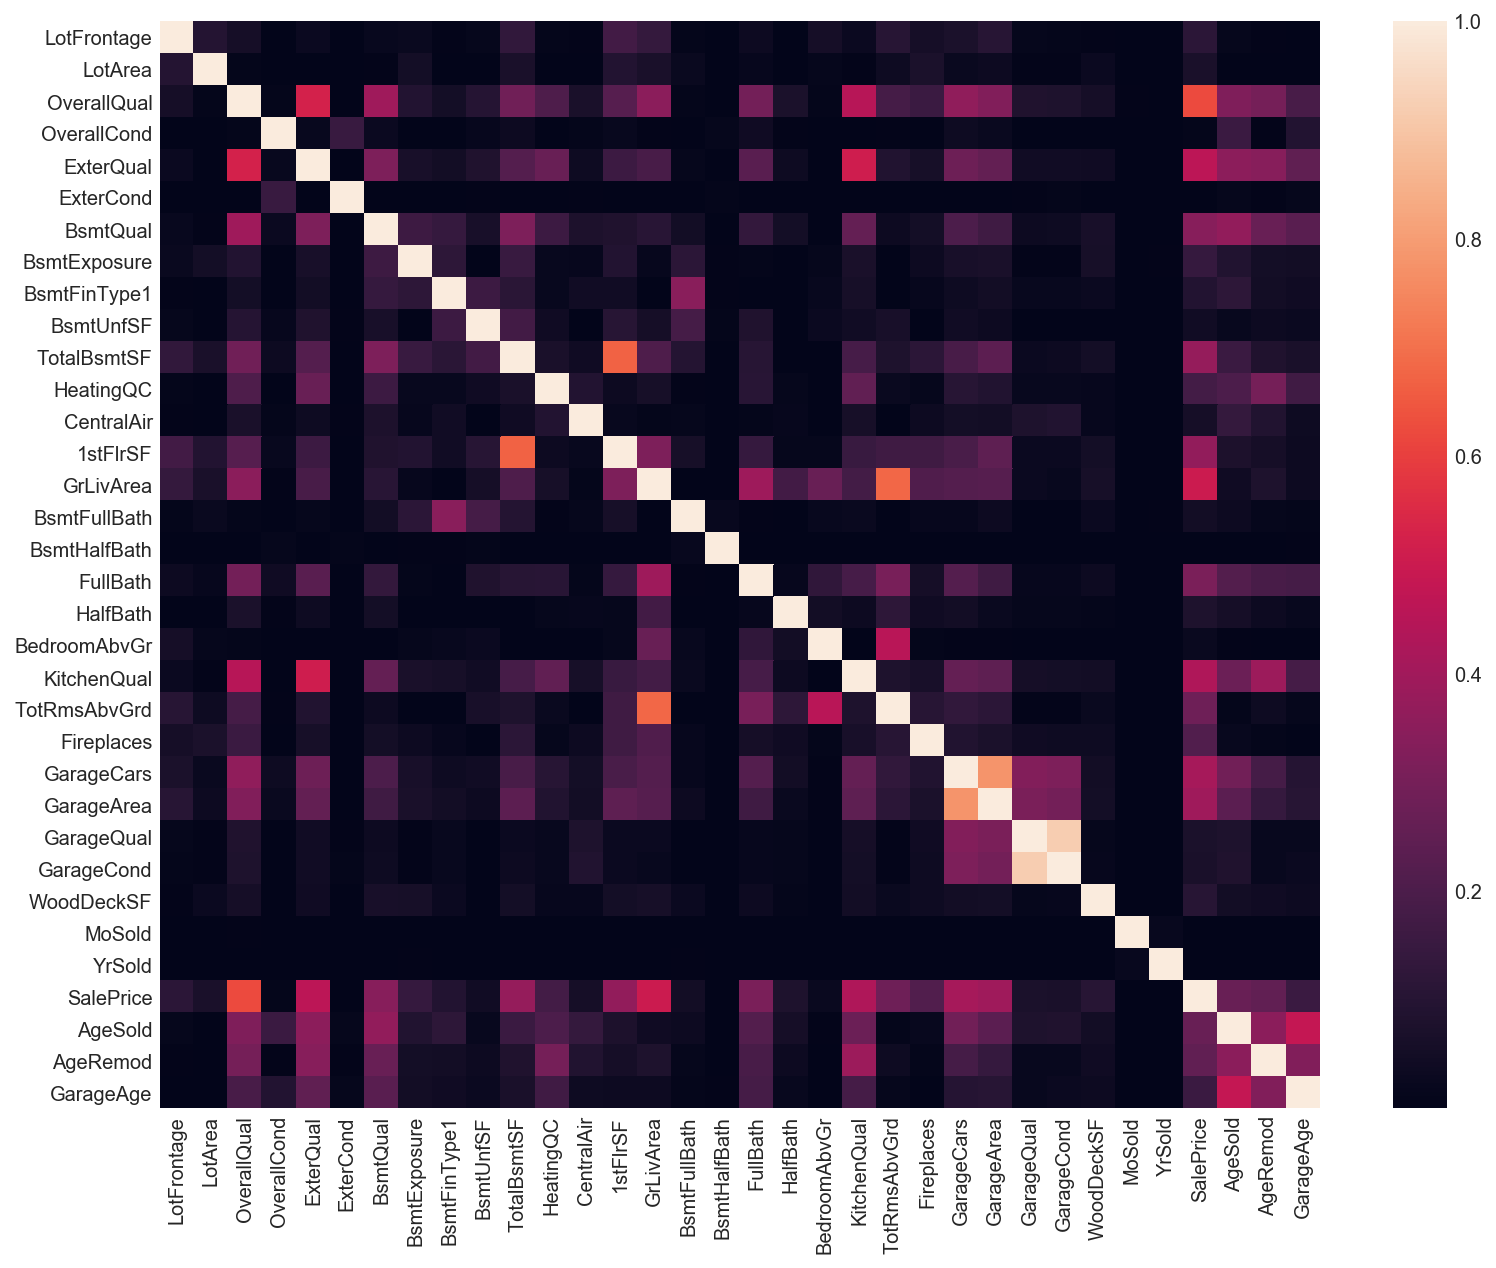

In [349]:
# look at the pearson correlation of the numeric features
fig = plt.figure(figsize=(13,10))
sns.heatmap(house.corr()**2)

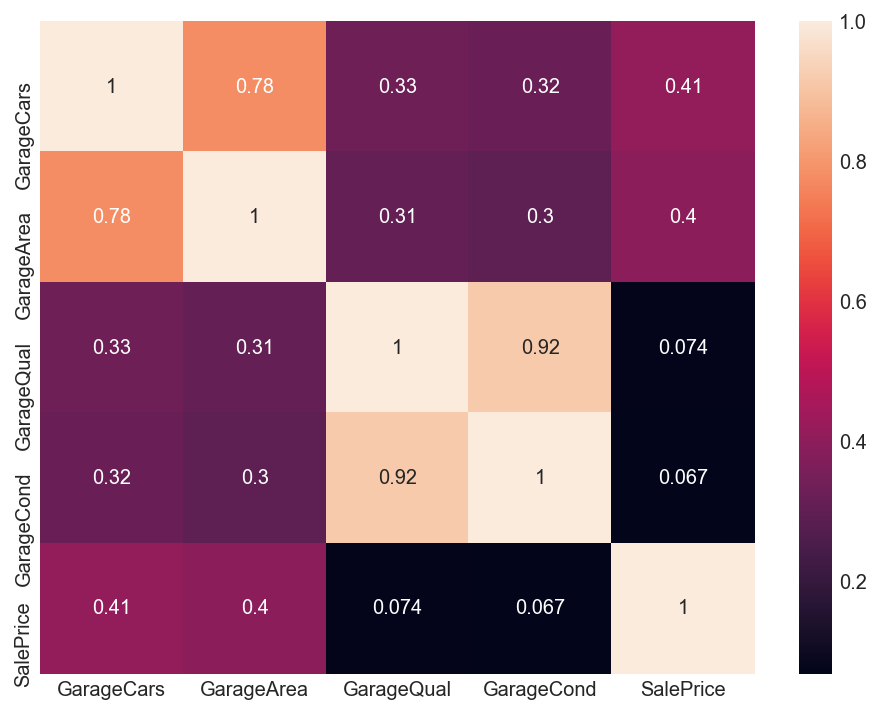

In [351]:
# only 4 variables look worrying, look at them further
fig = plt.figure(figsize=(8,6))
sns.heatmap(house[['GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'SalePrice']].corr()**2, annot=True)

In [352]:
# decide to drop GarageArea and GarageCond to reduce multicollinearity, 
# as they are less correlated to Sales Price compared to their counterparts
house.drop(['GarageArea', 'GarageCond'], axis=1, inplace=True)
house.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,GarageType,GarageFinish,GarageCars,GarageQual,PavedDrive,WoodDeckSF,MoSold,YrSold,SaleType,SaleCondition,SalePrice,AgeSold,AgeRemod,GarageAge,Condition,Exterior
0,60,RL,65.0,8450,Reg,Inside,CollgCr,1Fam,2Story,7,5,Gable,BrkFace,4,3,PConc,4,1,6,150,856,5,1,SBrkr,856,1710,1,0,2,1,3,4,8,0,Attchd,RFn,2,3,Y,0,2,2008,WD,Normal,208500,5,5,5,Norm,VinylSd
1,20,RL,80.0,9600,Reg,FR2,Veenker,1Fam,1Story,6,8,Gable,None,3,3,CBlock,4,4,5,284,1262,5,1,SBrkr,1262,1262,0,1,2,0,3,3,6,1,Attchd,RFn,2,3,Y,298,5,2007,WD,Normal,181500,31,31,31,Feedr,MetalSd
2,60,RL,68.0,11250,IR1,Inside,CollgCr,1Fam,2Story,7,5,Gable,BrkFace,4,3,PConc,4,2,6,434,920,5,1,SBrkr,920,1786,1,0,2,1,3,4,6,1,Attchd,RFn,2,3,Y,0,9,2008,WD,Normal,223500,7,6,7,Norm,VinylSd
3,70,RL,60.0,9550,IR1,Corner,Crawfor,1Fam,2Story,7,5,Gable,None,3,3,BrkTil,3,1,5,540,756,4,1,SBrkr,961,1717,1,0,1,0,3,4,7,1,Detchd,Unf,3,3,Y,0,2,2006,WD,Abnorml,140000,91,36,8,Norm,"Wd Sdng,WdShing"
4,60,RL,84.0,14260,IR1,FR2,NoRidge,1Fam,2Story,8,5,Gable,BrkFace,4,3,PConc,4,3,6,490,1145,5,1,SBrkr,1145,2198,1,0,2,1,4,4,9,1,Attchd,RFn,3,3,Y,192,12,2008,WD,Normal,250000,8,8,8,Norm,VinylSd


In [353]:
house.shape
# at the end of the day, we have 50 features left

(1449, 50)

### Prepare Matrices

In [354]:
# because patsy doesn't like column names that start with a digit, prefix it with an underscore
house.columns = ['_'+colname if colname[0].isdigit() else colname for colname in house.columns ]
house.columns

Index([u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea', u'LotShape',
       u'LotConfig', u'Neighborhood', u'BldgType', u'HouseStyle',
       u'OverallQual', u'OverallCond', u'RoofStyle', u'MasVnrType',
       u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual', u'BsmtExposure',
       u'BsmtFinType1', u'BsmtUnfSF', u'TotalBsmtSF', u'HeatingQC',
       u'CentralAir', u'Electrical', u'_1stFlrSF', u'GrLivArea',
       u'BsmtFullBath', u'BsmtHalfBath', u'FullBath', u'HalfBath',
       u'BedroomAbvGr', u'KitchenQual', u'TotRmsAbvGrd', u'Fireplaces',
       u'GarageType', u'GarageFinish', u'GarageCars', u'GarageQual',
       u'PavedDrive', u'WoodDeckSF', u'MoSold', u'YrSold', u'SaleType',
       u'SaleCondition', u'SalePrice', u'AgeSold', u'AgeRemod', u'GarageAge',
       u'Condition', u'Exterior'],
      dtype='object')

In [355]:
# shortlist the renovatable features based on the data description
# include anything that doesn't involve drastic reno (e.g. hacking, adding sq ft...)
reno_f = ['OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', \
         'Exterior', 'MasVnrType', 'MasVnrArea', \
         'ExterQual', 'ExterCond', 'BsmtCond', 'BsmtExposure', \
         'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', \
         'BsmtUnfSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', \
         'LowQualFinSF', 'KitchenQual', 'Functional', 'Fireplaces', \
         'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', \
         'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal']
# remove the features that we previously dropped
reno_f = [col for col in house.columns if col in reno_f]
print 'Renovatable features:\n', reno_f

# sale info
sale_f = ['MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'SalePrice']

# create list of fixed features
fixed_f = list(house.columns.drop(reno_f).drop(sale_f))
print '\nFixed features:\n', fixed_f

# check that all cols are accounted for
assert len(reno_f) + len(sale_f) + len(fixed_f) == len(house.columns)

Renovatable features:
['OverallQual', 'OverallCond', 'RoofStyle', 'MasVnrType', 'ExterQual', 'ExterCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtUnfSF', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Fireplaces', 'GarageFinish', 'GarageQual', 'PavedDrive', 'Exterior']

Fixed features:
['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape', 'LotConfig', 'Neighborhood', 'BldgType', 'HouseStyle', 'Foundation', 'BsmtQual', 'TotalBsmtSF', '_1stFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'GarageType', 'GarageCars', 'WoodDeckSF', 'AgeSold', 'AgeRemod', 'GarageAge', 'Condition']


In [356]:
# convert to matrices for training
formula = 'SalePrice ~ ' + ' + '.join(fixed_f)
print formula
y, X = patsy.dmatrices(formula, data=house, return_type='dataframe')
y = y.values.ravel()
# because of the weird patsy bug with the intercepts, manually drop intercept
X = X.drop('Intercept', axis=1)
print X.shape
X.head()

SalePrice ~ MSSubClass + MSZoning + LotFrontage + LotArea + LotShape + LotConfig + Neighborhood + BldgType + HouseStyle + Foundation + BsmtQual + TotalBsmtSF + _1stFlrSF + GrLivArea + BsmtFullBath + BsmtHalfBath + FullBath + HalfBath + BedroomAbvGr + TotRmsAbvGrd + GarageType + GarageCars + WoodDeckSF + AgeSold + AgeRemod + GarageAge + Condition
(1449, 101)


,MSSubClass[T.160],MSSubClass[T.180],MSSubClass[T.190],MSSubClass[T.20],MSSubClass[T.30],MSSubClass[T.40],MSSubClass[T.45],MSSubClass[T.50],MSSubClass[T.60],MSSubClass[T.70],MSSubClass[T.75],MSSubClass[T.80],MSSubClass[T.85],MSSubClass[T.90],MSZoning[T.RH],MSZoning[T.RL],MSZoning[T.RM],LotShape[T.IR2],LotShape[T.IR3],LotShape[T.Reg],LotConfig[T.CulDSac],LotConfig[T.FR2],LotConfig[T.FR3],LotConfig[T.Inside],Neighborhood[T.Blueste],Neighborhood[T.BrDale],Neighborhood[T.BrkSide],Neighborhood[T.ClearCr],Neighborhood[T.CollgCr],Neighborhood[T.Crawfor],Neighborhood[T.Edwards],Neighborhood[T.Gilbert],Neighborhood[T.IDOTRR],Neighborhood[T.MeadowV],Neighborhood[T.Mitchel],Neighborhood[T.NAmes],Neighborhood[T.NPkVill],Neighborhood[T.NWAmes],Neighborhood[T.NoRidge],Neighborhood[T.NridgHt],Neighborhood[T.OldTown],Neighborhood[T.SWISU],Neighborhood[T.Sawyer],Neighborhood[T.SawyerW],Neighborhood[T.Somerst],Neighborhood[T.StoneBr],Neighborhood[T.Timber],Neighborhood[T.Veenker],BldgType[T.2fmCon],BldgType[T.Duplex],...,BldgType[T.TwnhsE],HouseStyle[T.1.5Unf],HouseStyle[T.1Story],HouseStyle[T.2.5Fin],HouseStyle[T.2.5Unf],HouseStyle[T.2Story],HouseStyle[T.SFoyer],HouseStyle[T.SLvl],Foundation[T.CBlock],Foundation[T.PConc],Foundation[T.Slab],Foundation[T.Stone],Foundation[T.Wood],GarageType[T.Attchd],GarageType[T.Basment],GarageType[T.BuiltIn],GarageType[T.CarPort],GarageType[T.Detchd],GarageType[T.NA],"Condition[T.Artery,PosA]",Condition[T.Feedr],"Condition[T.Feedr,RRAe]","Condition[T.Feedr,RRAn]","Condition[T.Feedr,RRNn]",Condition[T.Norm],Condition[T.PosA],Condition[T.PosN],Condition[T.RRAe],Condition[T.RRAn],"Condition[T.RRAn,Feedr]",Condition[T.RRNe],Condition[T.RRNn],"Condition[T.RRNn,Feedr]",LotFrontage,LotArea,BsmtQual,TotalBsmtSF,_1stFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,GarageCars,WoodDeckSF,AgeSold,AgeRemod,GarageAge
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65.0,8450.0,4.0,856.0,856.0,1710.0,1.0,0.0,2.0,1.0,3.0,8.0,2.0,0.0,5.0,5.0,5.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,9600.0,4.0,1262.0,1262.0,1262.0,0.0,1.0,2.0,0.0,3.0,6.0,2.0,298.0,31.0,31.0,31.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.0,11250.0,4.0,920.0,920.0,1786.0,1.0,0.0,2.0,1.0,3.0,6.0,2.0,0.0,7.0,6.0,7.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,9550.0,3.0,756.0,961.0,1717.0,1.0,0.0,1.0,0.0,3.0,7.0,3.0,0.0,91.0,36.0,8.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84.0,14260.0,4.0,1145.0,1145.0,2198.0,1.0,0.0,2.0,1.0,4.0,9.0,3.0,192.0,8.0,8.0,8.0


In [357]:
# split into training and test set by year
test_ind = house['YrSold'] >=2010
X_train = X[~test_ind]
X_test = X[test_ind]
y_train = y[~test_ind]
y_test = y[test_ind]
print X_train.shape, X_test.shape, len(y_train), len(y_test)

(1277, 101) (172, 101) 1277 172


In [358]:
# standardise variables based on X_train, apply on X_test
ss = StandardScaler()
ss.fit(X_train)
Xs_train = ss.transform(X_train)
Xs_test = ss.transform(X_test)

### Model Building

In [360]:
# define a function to capture and plot the 10 best features from a logistic regression
def best_features(classifier, X):
    '''takes in a trained classifier and the X matrix, plots coefficients of the best 10 features 
    and returns a dataframe of all the coefficients'''
    
    # put coefficients into a nice dataframe
    var = pd.DataFrame({'coefs': classifier.coef_, 
                        'abs_coefs': np.abs(classifier.coef_),
                        'features': X.columns})

    # Number of non-zero coefficients
    print 'number of non-zero coefficients: {:d} / {:d}'.format((var.coefs!=0).sum(), Xs_test.shape[1])

    # plot coefficients of the 10 best features
    bestvars = var.sort_values('abs_coefs', ascending=False).head(10)
    bestvars.sort_values('coefs').plot(kind='barh', x='features', y='coefs')
    plt.xlabel('coefs')
    plt.title('Top 10 features')
    plt.show()
    
    # returns dataframe of all coefficients
    return var

#### Stochastic Gradient Descent with Gridsearch

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits


[Parallel(n_jobs=3)]: Done 305 tasks      | elapsed:    8.6s
[Parallel(n_jobs=3)]: Done 6000 out of 6000 | elapsed:   19.5s finished


{'penalty': 'l1', 'alpha': 802.64335222571742, 'loss': 'squared_loss'}
Best gridsearch score: 0.785380939831
Test score: 0.822380423719
number of non-zero coefficients: 56 / 101


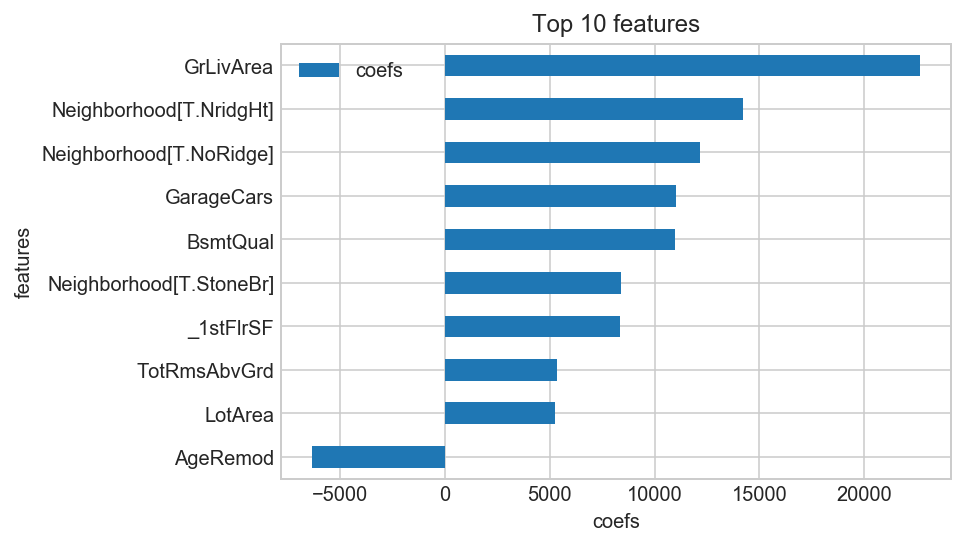

,abs_coefs,coefs,features
0,1910.920191,-1910.920191,MSSubClass[T.160]
1,0.000000,0.000000,MSSubClass[T.180]
2,189.780625,-189.780625,MSSubClass[T.190]
3,1000.478050,1000.478050,MSSubClass[T.20]
4,0.000000,0.000000,MSSubClass[T.30]
5,0.000000,0.000000,MSSubClass[T.40]
6,0.000000,0.000000,MSSubClass[T.45]
7,0.000000,0.000000,MSSubClass[T.50]
8,962.160997,962.160997,MSSubClass[T.60]
9,0.000000,0.000000,MSSubClass[T.70]


In [361]:
# try using stochastic gradient descent and gridsearch
# set parameters for gridsearch
sgd_params = {
    'loss': ['squared_loss', 'huber'],
    'penalty': ['none', 'l1', 'l2'],
    'alpha': np.logspace(2, 4, 200)
}

# set up the regressor
sgd_reg = SGDRegressor(random_state=rs)
sgd_reg_gs = GridSearchCV(sgd_reg, sgd_params, cv=5, verbose=1, n_jobs=njobs)

# fit
sgd_reg_gs.fit(Xs_train, y_train)

# evaluate model
print sgd_reg_gs.best_params_
print 'Best gridsearch score:', sgd_reg_gs.best_score_
print 'Test score:', sgd_reg_gs.best_estimator_.score(Xs_test, y_test)

# examine top 10 variables
best_features(sgd_reg_gs.best_estimator_, X)

#### Linear Regression with Lasso Penalty

optimal alpha: 614.500078837
R^2: 0.834458881814
number of non-zero coefficients: 60 / 101


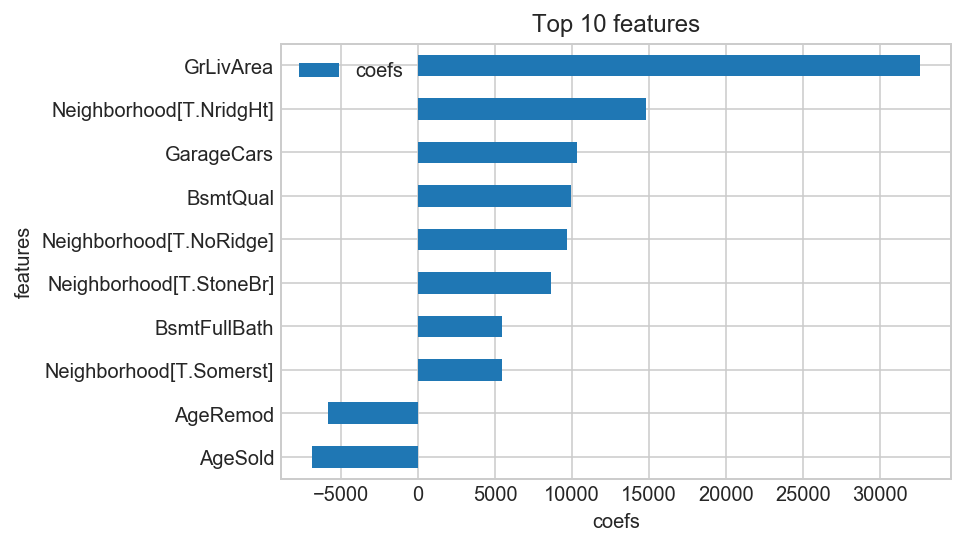

,abs_coefs,coefs,features
0,3337.177279,-3337.177279,MSSubClass[T.160]
1,0.000000,-0.000000,MSSubClass[T.180]
2,0.000000,-0.000000,MSSubClass[T.190]
3,3897.102792,3897.102792,MSSubClass[T.20]
4,0.000000,0.000000,MSSubClass[T.30]
5,0.000000,0.000000,MSSubClass[T.40]
6,0.000000,0.000000,MSSubClass[T.45]
7,0.000000,-0.000000,MSSubClass[T.50]
8,0.000000,-0.000000,MSSubClass[T.60]
9,0.000000,0.000000,MSSubClass[T.70]


In [423]:
# try using LassoCV to see if we get better results
lasso1 = LassoCV(n_alphas= 200, cv=5, random_state=rs)
lasso1.fit(Xs_train, y_train)

print 'optimal alpha:', lasso1.alpha_
print 'R^2:', lasso1.score(Xs_test, y_test)
# looks like the model is not bad... R^2 of 0.841

# examine the top 10 features
best_features(lasso1, X)

### Conclusion:

The linear regression with lasso penalty obtained the better R^2 score (0.834 over 0.822), but retained more features (60 instead of 56).

Both methods produced similar top 10 features, with 7 out of 10 being the same.

For both, the feature GrLivArea, above ground living area square feet, had the most positive effect on the sale price of the house.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [363]:
# A:
# calculate the price effect of renovatable features
ry_train = y_train - lasso.predict(Xs_train)
ry_test = y_test - lasso.predict(Xs_test)

In [365]:
# create the new matrix for renovatable features
formula = ' + '.join(reno_f)
print formula
rX = patsy.dmatrix(formula, data=house, return_type='dataframe')
rX = rX.drop('Intercept', axis=1)
print rX.shape
rX.head()

OverallQual + OverallCond + RoofStyle + MasVnrType + ExterQual + ExterCond + BsmtExposure + BsmtFinType1 + BsmtUnfSF + HeatingQC + CentralAir + Electrical + KitchenQual + Fireplaces + GarageFinish + GarageQual + PavedDrive + Exterior
(1449, 96)


,RoofStyle[T.Gable],RoofStyle[T.Gambrel],RoofStyle[T.Hip],RoofStyle[T.Mansard],RoofStyle[T.Shed],MasVnrType[T.BrkFace],MasVnrType[T.NA],MasVnrType[T.None],MasVnrType[T.Stone],Electrical[T.FuseF],Electrical[T.FuseP],Electrical[T.Mix],Electrical[T.SBrkr],GarageFinish[T.NA],GarageFinish[T.RFn],GarageFinish[T.Unf],PavedDrive[T.P],PavedDrive[T.Y],"Exterior[T.AsbShng,Plywood]","Exterior[T.AsbShng,Stucco]",Exterior[T.AsphShn],Exterior[T.BrkComm],Exterior[T.BrkFace],"Exterior[T.BrkFace,AsbShng]","Exterior[T.BrkFace,HdBoard]","Exterior[T.BrkFace,Plywood]","Exterior[T.BrkFace,Stone]","Exterior[T.BrkFace,Stucco]","Exterior[T.BrkFace,Wd Sdng]","Exterior[T.BrkFace,WdShing]",Exterior[T.CBlock],Exterior[T.CemntBd],"Exterior[T.CemntBd,Wd Sdng]","Exterior[T.CemntBd,WdShing]",Exterior[T.HdBoard],"Exterior[T.HdBoard,AsphShn]","Exterior[T.HdBoard,ImStucc]","Exterior[T.HdBoard,MetalSd]","Exterior[T.HdBoard,Plywood]","Exterior[T.HdBoard,Wd Sdng]","Exterior[T.HdBoard,WdShing]",Exterior[T.ImStucc],Exterior[T.MetalSd],"Exterior[T.MetalSd,AsphShn]","Exterior[T.MetalSd,HdBoard]","Exterior[T.MetalSd,Stucco]","Exterior[T.MetalSd,Wd Sdng]","Exterior[T.MetalSd,WdShing]",Exterior[T.Plywood],"Exterior[T.Plywood,BrkComm]","Exterior[T.Plywood,HdBoard]","Exterior[T.Plywood,ImStucc]","Exterior[T.Plywood,Wd Sdng]",Exterior[T.Stone],"Exterior[T.Stone,HdBoard]",Exterior[T.Stucco],"Exterior[T.Stucco,CemntBd]","Exterior[T.Stucco,Stone]","Exterior[T.Stucco,WdShing]",Exterior[T.VinylSd],"Exterior[T.VinylSd,AsbShng]","Exterior[T.VinylSd,HdBoard]","Exterior[T.VinylSd,ImStucc]","Exterior[T.VinylSd,Other]","Exterior[T.VinylSd,Plywood]","Exterior[T.VinylSd,Stucco]","Exterior[T.VinylSd,Wd Sdng]","Exterior[T.VinylSd,WdShing]",Exterior[T.Wd Sdng],"Exterior[T.Wd Sdng,AsbShng]","Exterior[T.Wd Sdng,BrkFace]","Exterior[T.Wd Sdng,HdBoard]","Exterior[T.Wd Sdng,ImStucc]","Exterior[T.Wd Sdng,MetalSd]","Exterior[T.Wd Sdng,Plywood]","Exterior[T.Wd Sdng,Stone]","Exterior[T.Wd Sdng,Stucco]","Exterior[T.Wd Sdng,VinylSd]","Exterior[T.Wd Sdng,WdShing]",Exterior[T.WdShing],"Exterior[T.WdShing,HdBoard]","Exterior[T.WdShing,Plywood]","Exterior[T.WdShing,Stucco]","Exterior[T.WdShing,Wd Sdng]",OverallQual,OverallCond,ExterQual,ExterCond,BsmtExposure,BsmtFinType1,BsmtUnfSF,HeatingQC,CentralAir,KitchenQual,Fireplaces,GarageQual
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,5.0,4.0,3.0,1.0,6.0,150.0,5.0,1.0,4.0,0.0,3.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,8.0,3.0,3.0,4.0,5.0,284.0,5.0,1.0,3.0,1.0,3.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,5.0,4.0,3.0,2.0,6.0,434.0,5.0,1.0,4.0,1.0,3.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,7.0,5.0,3.0,3.0,1.0,5.0,540.0,4.0,1.0,4.0,1.0,3.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [367]:
# split into training and test set by year
rX_train = rXs[~test_ind, :]
rX_test = rXs[test_ind, :]

# standardise variables
ss = StandardScaler()
rXs_train = ss.fit_transform(rX_train)
rXs_test = ss.transform(rX_test)

#### Linear Regression with Lasso Penalty

optimal alpha: 901.081204393
R^2: 0.122282219863
number of non-zero coefficients: 29 / 101


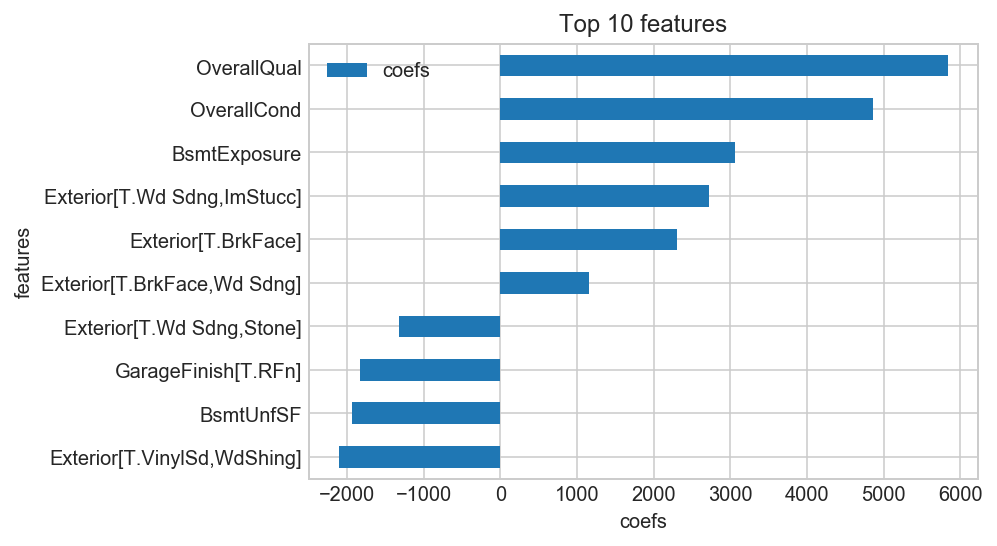

In [375]:
# again, use lasso linear regression
lasso = LassoCV(n_alphas=200, cv=5, verbose=0, n_jobs=njobs, random_state=rs)
lasso.fit(rXs_train, ry_train)
print 'optimal alpha:', lasso.alpha_
print 'R^2:', lasso.score(rXs_test, ry_test)

# examine top 10 features
lasso_coefs = best_features(lasso, rX)

#### Linear Regression with Elastic Net

optimal alpha: 923.794909529
optimal l1 ratio: 1.0
R^2: 0.12167848925
number of non-zero coefficients: 29 / 101


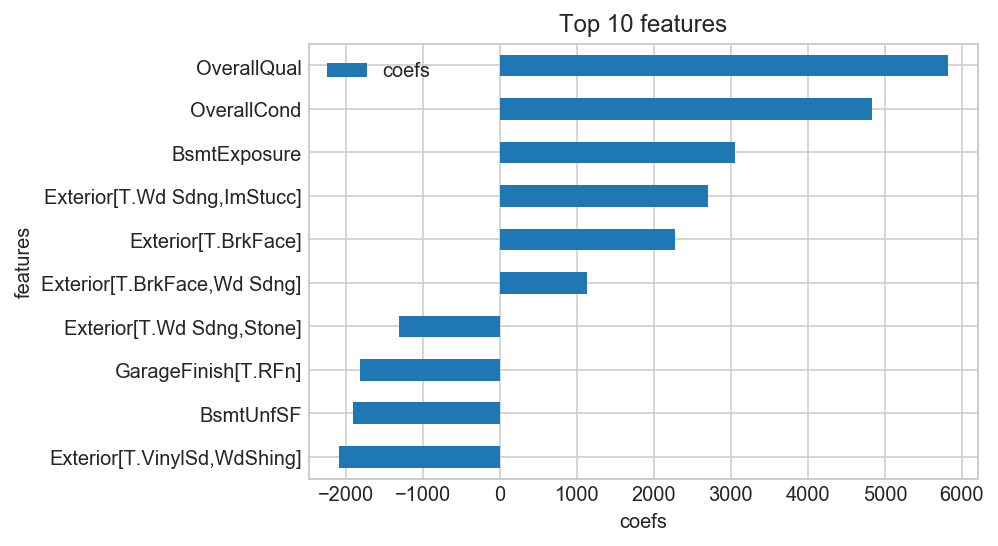

In [381]:
# try elastic net
l1_ratios = np.linspace(0.01, 1.0, 25)
enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=5, verbose=0)
enet.fit(rXs_train, ry_train)

print 'optimal alpha:', enet.alpha_
print 'optimal l1 ratio:', enet.l1_ratio_
print 'R^2:', enet.score(rXs_test, ry_test)

# examine top 10 features
enet_coefs = best_features(enet, rX)

Since we obtain an optimal l1 ratio of 1.0, the most optimal method is still lasso and the results are identical.

### Effect in dollars of the renovate-able features

In [399]:
# based on the lasso model, find out the effect in dollars of the renovate-able features
lasso_coefs['$ effect'] = lasso_coefs['coefs'] * ss.scale_
lasso_coefs.sort_values('abs_coefs', ascending=False)

,abs_coefs,coefs,features,scaled_coefs,$ effect
84,5837.350363,5837.350363,OverallQual,5871.005398,5871.005398
85,4856.310763,4856.310763,OverallCond,4832.328626,4832.328626
88,3061.122442,3061.122442,BsmtExposure,3081.656862,3081.656862
72,2718.552217,2718.552217,"Exterior[T.Wd Sdng,ImStucc]",2895.447768,2895.447768
22,2296.922317,2296.922317,Exterior[T.BrkFace],2281.827194,2281.827194
67,2104.160172,-2104.160172,"Exterior[T.VinylSd,WdShing]",-1737.132824,-1737.132824
90,1933.809669,-1933.809669,BsmtUnfSF,-1952.428273,-1952.428273
14,1831.631146,-1831.631146,GarageFinish[T.RFn],-1829.581511,-1829.581511
75,1324.856433,-1324.856433,"Exterior[T.Wd Sdng,Stone]",-1411.196086,-1411.196086
28,1151.566984,1151.566984,"Exterior[T.BrkFace,Wd Sdng]",1062.988503,1062.988503


The model predicts the effect in dollars of increasing 1 unit of the renovateable features. aka. increasing the OverallQual (rating of overall material and finish of the house) by 1 unit would increase the sales price of the house by approximately $5,871.

The features that can make money are the ones where the effect in dollars is more than the cost of performing the renovations.


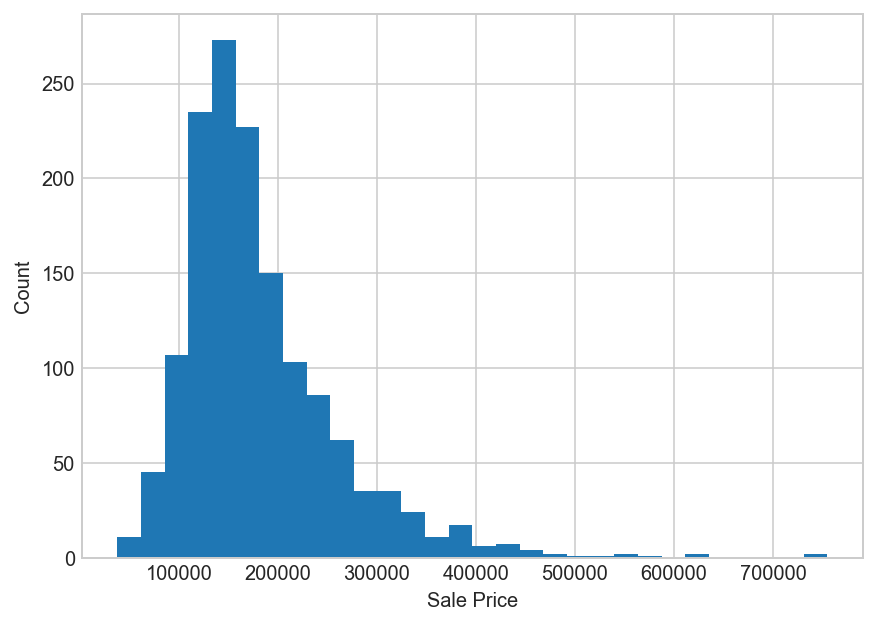

Effect of increasing 1 unit of the most important renovatable feature with respect to median house price: 3.58%


In [418]:
# look at the effects of the renovatable features in the perspective of the Sale Price
fig = plt.figure(figsize=(7,5))
_ = house.SalePrice.hist(bins=30)
_ = plt.xlabel('Sale Price')
_ = plt.ylabel('Count')
plt.show()

print 'Effect of increasing 1 unit of the most important renovatable feature with respect to median house price: {:0.3}%'.format(lasso_coefs.scaled_coefs.max() / house.SalePrice.median() * 100)

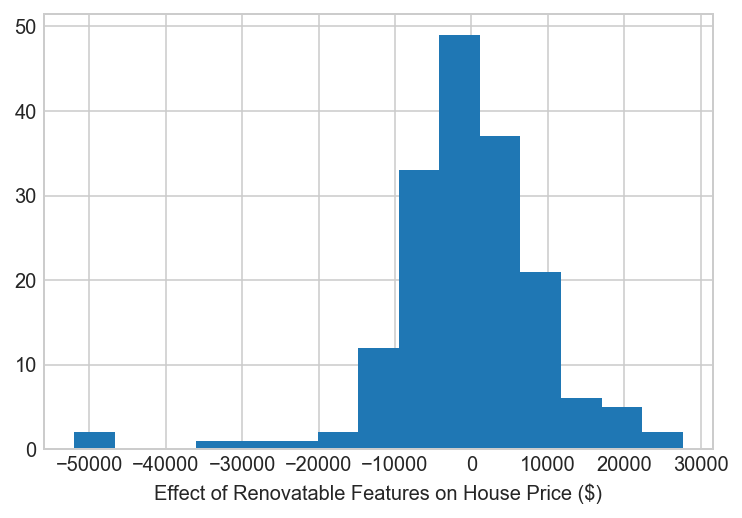

In [419]:
# overall effect of renovatable features on house price
ry_pred = lasso.predict(rXs_test)
_= plt.hist(ry_pred, bins=15)
_ = plt.xlabel('Effect of Renovatable Features on House Price ($)')

#### How to make money:
1. use the first model and second model (with pre-renovation features) to estimate how much the house should cost. if the offer price is lower than that, buy it.
2. increase the value of the house by doing renovation on the features identified by the second model (where dollar effect of renovations > cost of renovations)

### Model Evaluation

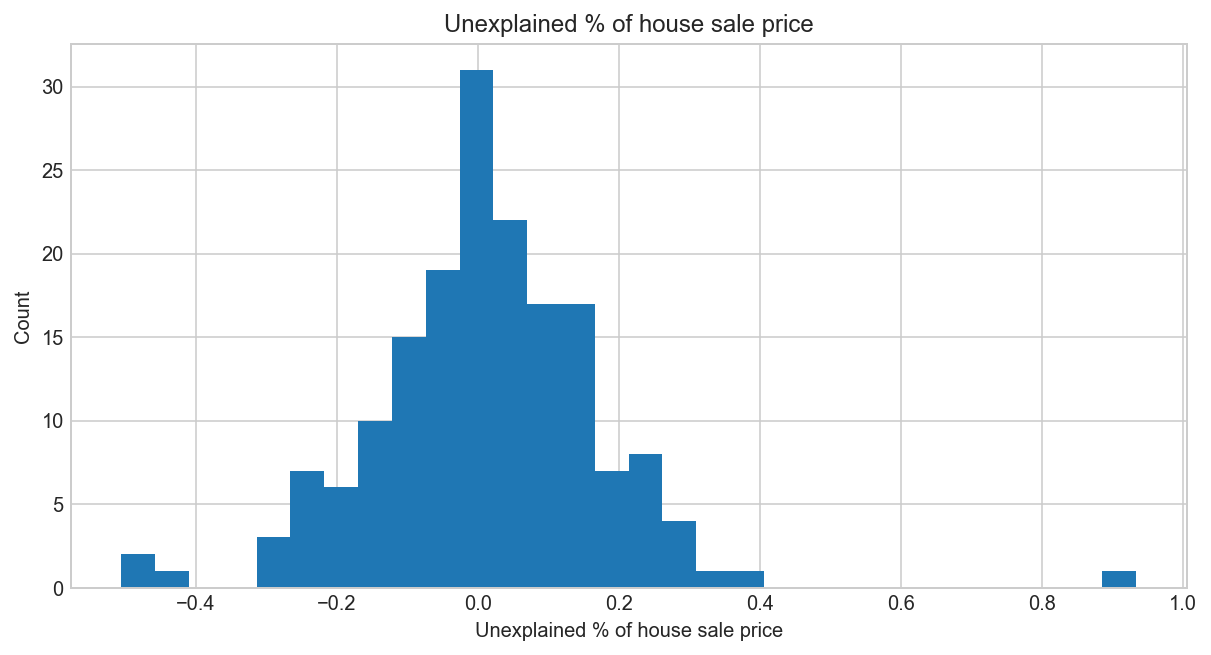

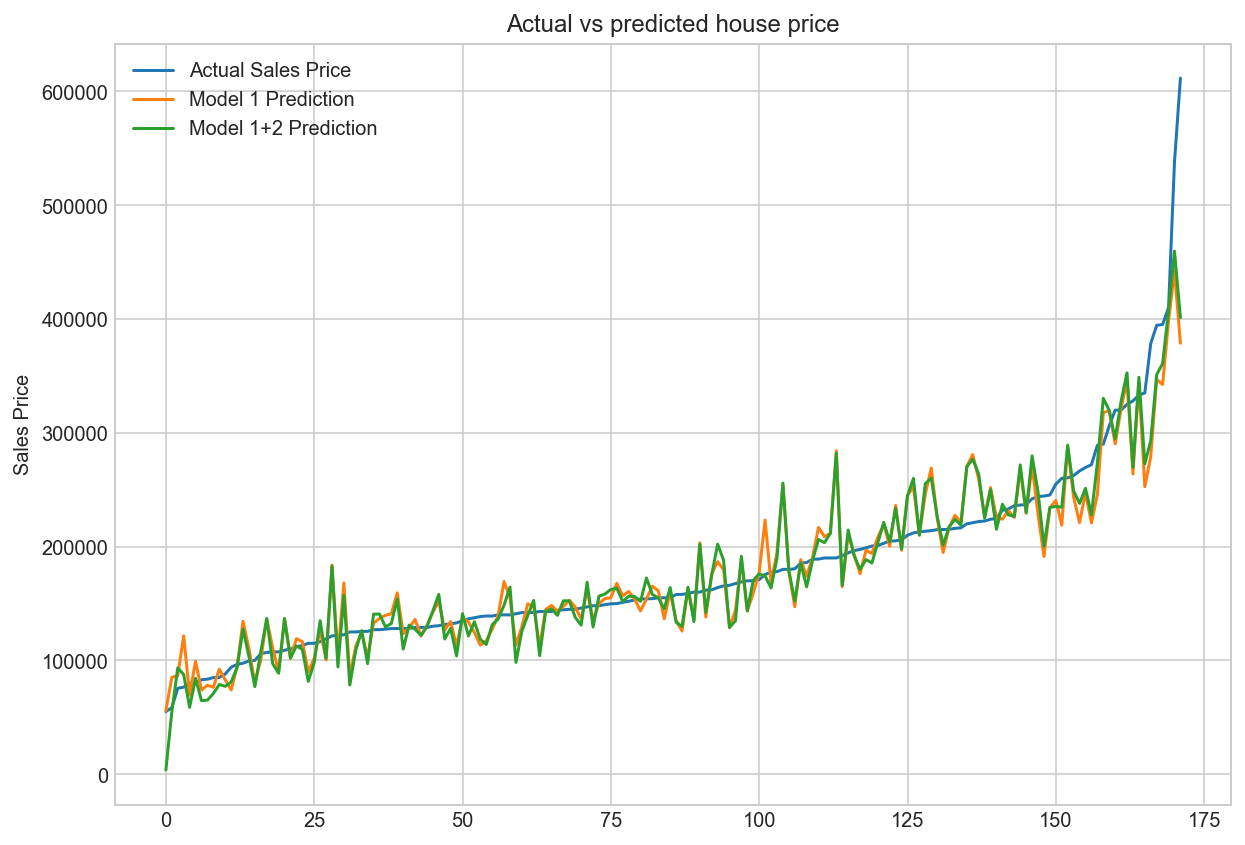

In [439]:
# sort real price
y_test_s = sorted([(y, ind) for ind, y in enumerate(y_test)])
y_test_s, ind = zip(*y_test_s)
y_model1 = lasso1.predict(Xs_test)[list(ind)]
y_model2 = y_model1 + lasso.predict(rXs_test)[list(ind)]

# unexplained variance in house price
unexp_price = (y_test_s - y_model2)/y_test_s
fig = plt.figure(figsize=(10,5))
ax = fig.gca()
ax = plt.hist(unexp_price, bins=30)
ax = plt.xlabel('Unexplained % of house sale price')
ax = plt.ylabel('Count')
ax = plt.title('Unexplained % of house sale price')

# plot all the predictions
fig = plt.figure(figsize=(10,7))
ax = fig.gca()
ax = plt.plot(y_test_s)
ax = plt.plot(y_model1)
ax = plt.plot(y_model2)
ax = plt.ylabel('Sales Price')
ax = plt.title('Actual vs predicted house price')
ax = plt.legend(['Actual Sales Price', 'Model 1 Prediction', 'Model 1+2 Prediction'])

Since the R^2 of model 2 is only 0.12 and the unexplained % of sale price using both models is high, I would not solely rely on the models to decide on what properties to buy and renovate. There are likely other features that affect the sales price which are not included in the model. If we could identify and measure these features, it would improve the predictive accuracy of the model.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [441]:
# A:
# examine how imbalanced this dataset is
print house.SaleCondition.value_counts()
print '-------'
ratio = house.SaleCondition[house.SaleCondition == 'Abnorml'].count() / float(house.shape[0])
print 'Ratio:', ratio*100, '%'
print 'The dataset is extremely imbalanced!'
print '-------'

# create a new target feature with 1 = abnormal and 0 = everything else
house['ClassTarget'] = [1 if cond=='Abnorml' else 0 for cond in house['SaleCondition']]
print house.ClassTarget.value_counts()

Normal     1193
Partial     125
Abnorml      96
Family       20
Alloca       11
AdjLand       4
Name: SaleCondition, dtype: int64
-------
Ratio: 6.62525879917 %
The dataset is extremely imbalanced!
-------
0    1353
1      96
Name: ClassTarget, dtype: int64


In [475]:
# prepare X & y
formula = 'ClassTarget ~ ' + ' + '.join(list(fixed_f) + reno_f)
cy, cX = patsy.dmatrices(formula, data=house, return_type='dataframe')
cX = cX.drop('Intercept', axis=1)
cy= cy.values.ravel()
# print cX.shape
# cX.head()

# split into training & test sets
cX_train, cX_test, cy_train, cy_test = train_test_split(cX, cy, test_size=0.3, random_state=rs)
# print cX_train.shape, cX_test.shape, len(cy_train), len(cy_test)
# print cy_train.mean(), cy_test.mean()

# standardise X
ss = StandardScaler()
ss.fit(cX_train)
cXs_train = ss.transform(cX_train)
cXs_test = ss.transform(cX_test)

ss = StandardScaler()
cXs = ss.fit_transform(cX)

# calc baseline accuracy
base_acc = 1- cy_test.mean()
print 'Baseline accuracy:', base_acc

Baseline accuracy: 0.937931034483


#### Strategy 1: Changing class weights

In [467]:
# try changing the class weights
logreg = LogisticRegressionCV(class_weight= 'balanced', penalty='l1', solver='liblinear', max_iter= 300, Cs=10, cv=5, verbose=1, n_jobs=njobs, random_state=rs)
logreg.fit(cXs_train, cy_train)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   39.6s remaining:   59.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   44.8s finished


LogisticRegressionCV(Cs=10, class_weight='balanced', cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=300,
           multi_class='ovr', n_jobs=-1, penalty='l1', random_state=3,
           refit=True, scoring=None, solver='liblinear', tol=0.0001,
           verbose=1)

In [471]:
# use model to predict y
cy_pred = logreg.predict(cXs_test)
cy_prob = logreg.predict_proba(cXs_test)

# # capture coefficients
# feature_impt[sampler[0]] = classifier.coef_.T

# display confusion matrix & classification report
print 'Confusion Matrix:'
print confusion_matrix(cy_test, cy_pred)
print classification_report(cy_test, cy_pred)


Confusion Matrix:
[[408   0]
 [ 27   0]]
             precision    recall  f1-score   support

        0.0       0.94      1.00      0.97       408
        1.0       0.00      0.00      0.00        27

avg / total       0.88      0.94      0.91       435



Changing the class weights doesn't seem to help. Try something else.

### Strategy 2: Brute Force Search

In [506]:
# try classifiers and sampling techniques without tuning hyperparameters to see which method is most promising

# create a dummy class for no sampling
class NoSampling(object):
    
    def fit_sample(self, X, y):
        return X, y

# try out a bunch of classifiers to see which is worth pursuing further
classifiers = [
    ['Logistic Regression with Lasso', LogisticRegressionCV(penalty='l1', solver='liblinear', max_iter= 500, Cs=10, cv=5, verbose=1, n_jobs=njobs, random_state=rs)],
    ['Logistic Regression with Ridge', LogisticRegressionCV(penalty='l2', max_iter= 500, Cs=10, cv=5, verbose=1, n_jobs=njobs, random_state=rs)],
    ['KNN', KNeighborsClassifier(n_jobs=njobs)],
    ['SVM (linear kernel)', SVC(kernel = 'linear', probability=True, verbose=1, random_state=rs)],
    ['SVM (rbf kernel)', SVC(kernel = 'rbf', probability=True, verbose=1, random_state=rs)]
]

# list out the sampling techniques that we are comparing
samplers = [
    ['No Sampling', NoSampling()],
    ['Random Oversampler', RandomOverSampler(random_state=rs)],
    ['SMOTE', SMOTE(ratio='minority', k_neighbors=3, random_state=rs)],
    ['SMOTE Tomek', SMOTETomek(random_state=rs)],
    ['SMOTE ENN', SMOTEENN(random_state=rs)]
#     ['ADASYN', ADASYN(random_state=rs)],
#     ['Tomek Links', TomekLinks(random_state=rs)]
]

In [507]:
# initialise dataframe for capturing coefficients of each feature
feature_impt = pd.DataFrame(cX.columns, columns=['Features'])
l_classifier = []
l_resampler = []
l_recall = []
l_precision = []

# loop through all the classifiers
for classifier in classifiers:
    print '------------------------'
    print '###############', classifier[0], '###############'
    print '------------------------'
    
    # loop through all the types of samplers
    for sampler in samplers:
        
        print '-------', sampler[0], '-------'
        
        # perform sampling
        cXs_train_sm, cy_train_sm = sampler[1].fit_sample(cXs_train, cy_train)
        print 'Ratio of training set:', cy_train_sm.mean()

        # apply regression
        classifier[1].fit(cXs_train_sm, cy_train_sm)

        # use model to predict y
        cy_pred = classifier[1].predict(cXs_test)
        cy_prob = classifier[1].predict_proba(cXs_test)

        # capture coefficients, if it is a logistic regression
        if 'Regression' in classifier[0]:
            feature_impt[classifier[0] + ' - ' + sampler[0]] = classifier[1].coef_.T

        # display confusion matrix & classification report
        print 'Confusion Matrix:'
        print confusion_matrix(cy_test, cy_pred)
        print classification_report(cy_test, cy_pred)
        
        # save
        l_recall.append(recall_score(cy_test, cy_pred))
        l_precision.append(precision_score(cy_test, cy_pred))
        l_classifier.append(classifier[0])
        l_resampler.append(sampler[0])
        

------------------------
############### Logistic Regression with Lasso ###############
------------------------
------- No Sampling -------
Ratio of training set: 0.0680473372781


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.0min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


Confusion Matrix:
[[408   0]
 [ 27   0]]
             precision    recall  f1-score   support

        0.0       0.94      1.00      0.97       408
        1.0       0.00      0.00      0.00        27

avg / total       0.88      0.94      0.91       435

------- Random Oversampler -------
Ratio of training set: 0.5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   51.5s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   59.3s finished


Confusion Matrix:
[[336  72]
 [ 18   9]]
             precision    recall  f1-score   support

        0.0       0.95      0.82      0.88       408
        1.0       0.11      0.33      0.17        27

avg / total       0.90      0.79      0.84       435

------- SMOTE -------
Ratio of training set: 0.5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   47.1s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.2min finished


Confusion Matrix:
[[328  80]
 [ 17  10]]
             precision    recall  f1-score   support

        0.0       0.95      0.80      0.87       408
        1.0       0.11      0.37      0.17        27

avg / total       0.90      0.78      0.83       435

------- SMOTE Tomek -------
Ratio of training set: 0.5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 89.0min remaining: 133.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 89.3min finished


Confusion Matrix:
[[332  76]
 [ 17  10]]
             precision    recall  f1-score   support

        0.0       0.95      0.81      0.88       408
        1.0       0.12      0.37      0.18        27

avg / total       0.90      0.79      0.83       435

------- SMOTE ENN -------
Ratio of training set: 0.609915198956


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 23.3min remaining: 35.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 26.8min finished


Confusion Matrix:
[[294 114]
 [ 17  10]]
             precision    recall  f1-score   support

        0.0       0.95      0.72      0.82       408
        1.0       0.08      0.37      0.13        27

avg / total       0.89      0.70      0.78       435

------------------------
############### Logistic Regression with Ridge ###############
------------------------
------- No Sampling -------
Ratio of training set: 0.0680473372781


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.8s remaining:   11.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.3s finished


Confusion Matrix:
[[408   0]
 [ 27   0]]
             precision    recall  f1-score   support

        0.0       0.94      1.00      0.97       408
        1.0       0.00      0.00      0.00        27

avg / total       0.88      0.94      0.91       435

------- Random Oversampler -------
Ratio of training set: 0.5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.5s remaining:    9.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.9s finished


Confusion Matrix:
[[336  72]
 [ 17  10]]
             precision    recall  f1-score   support

        0.0       0.95      0.82      0.88       408
        1.0       0.12      0.37      0.18        27

avg / total       0.90      0.80      0.84       435

------- SMOTE -------
Ratio of training set: 0.5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.2s remaining:   10.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.5s finished


Confusion Matrix:
[[328  80]
 [ 17  10]]
             precision    recall  f1-score   support

        0.0       0.95      0.80      0.87       408
        1.0       0.11      0.37      0.17        27

avg / total       0.90      0.78      0.83       435

------- SMOTE Tomek -------
Ratio of training set: 0.5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.3s remaining:   11.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.3s finished


Confusion Matrix:
[[333  75]
 [ 17  10]]
             precision    recall  f1-score   support

        0.0       0.95      0.82      0.88       408
        1.0       0.12      0.37      0.18        27

avg / total       0.90      0.79      0.84       435

------- SMOTE ENN -------
Ratio of training set: 0.609915198956


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.4s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.0s finished


Confusion Matrix:
[[297 111]
 [ 16  11]]
             precision    recall  f1-score   support

        0.0       0.95      0.73      0.82       408
        1.0       0.09      0.41      0.15        27

avg / total       0.90      0.71      0.78       435

------------------------
############### KNN ###############
------------------------
------- No Sampling -------
Ratio of training set: 0.0680473372781
Confusion Matrix:
[[408   0]
 [ 27   0]]
             precision    recall  f1-score   support

        0.0       0.94      1.00      0.97       408
        1.0       0.00      0.00      0.00        27

avg / total       0.88      0.94      0.91       435

------- Random Oversampler -------
Ratio of training set: 0.5
Confusion Matrix:
[[321  87]
 [ 16  11]]
             precision    recall  f1-score   support

        0.0       0.95      0.79      0.86       408
        1.0       0.11      0.41      0.18        27

avg / total       0.90      0.76      0.82       435

------- SMOTE ---

##### Recall = tp / (tp + fn) 
- Ability of classifier to find all the true samples
- We want a high recall on the minority class (1), so that we can identify more sales that are abnormal

In [523]:
# identify the combination of classifier and resampler that obtains the best recall
recall_df = pd.DataFrame({'Classifier': l_classifier, 'Resampler':l_resampler, 
                          'Recall':l_recall, 'Precision': l_precision})
recall_df = recall_df[['Classifier', 'Resampler', 'Recall', 'Precision']]
recall_df.sort_values('Recall', ascending=False)


KeyError: "['Precision'] not in index"

In [524]:
# identify the combination of classifier and resampler that obtains the best recall
recall_df = pd.DataFrame({'Classifier': l_classifier, 'Resampler':l_resampler, 
                          'Recall':l_recall})
recall_df = recall_df[['Classifier', 'Resampler', 'Recall']]
recall_df.sort_values('Recall', ascending=False)


,Classifier,Resampler,Recall
14,KNN,SMOTE ENN,0.629630
12,KNN,SMOTE,0.518519
13,KNN,SMOTE Tomek,0.518519
18,SVM (linear kernel),SMOTE Tomek,0.444444
19,SVM (linear kernel),SMOTE ENN,0.444444
11,KNN,Random Oversampler,0.407407
9,Logistic Regression with Ridge,SMOTE ENN,0.407407
17,SVM (linear kernel),SMOTE,0.370370
8,Logistic Regression with Ridge,SMOTE Tomek,0.370370
7,Logistic Regression with Ridge,SMOTE,0.370370


From the prelim runs above, looks like the best recall is obtained using SMOTE-ENN and a KNN classifier. However, looking at the classification report, SMOTE-ENN optimises the recall of the minority class (0.63) at the expense of the recall of the majority class (0.54). This means that more normal sales will be wrongly classified as abnormal, which is problematic.

SMOTE alone does better, with a recall of 0.52 (minority) and 0.70 (majority). Choose to use SMOTE + KNN for further optimisation and validation

### Optimise the chosen classifier and resampler and validate with CV

Perform optimisation and validation by useing gridsearch to tune hyperparameters of chosen classifier.

SMOTE k= 1
Ratio of training set: 0.5
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   15.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   47.8s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:  1.2min finished


{'n_neighbors': 17, 'weights': 'distance', 'p': 1}
Confusion Matrix:
[[278 130]
 [ 14  13]]
             precision    recall  f1-score   support

        0.0       0.95      0.68      0.79       408
        1.0       0.09      0.48      0.15        27

avg / total       0.90      0.67      0.75       435

SMOTE k= 3
Ratio of training set: 0.5
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   14.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   50.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:  1.3min finished


{'n_neighbors': 13, 'weights': 'distance', 'p': 1}
Confusion Matrix:
[[289 119]
 [ 15  12]]
             precision    recall  f1-score   support

        0.0       0.95      0.71      0.81       408
        1.0       0.09      0.44      0.15        27

avg / total       0.90      0.69      0.77       435

SMOTE k= 5
Ratio of training set: 0.5
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   13.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   47.5s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:  1.2min finished


{'n_neighbors': 11, 'weights': 'distance', 'p': 1}
Confusion Matrix:
[[298 110]
 [ 16  11]]
             precision    recall  f1-score   support

        0.0       0.95      0.73      0.83       408
        1.0       0.09      0.41      0.15        27

avg / total       0.90      0.71      0.78       435

SMOTE k= 7
Ratio of training set: 0.5
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   14.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:  1.3min finished


{'n_neighbors': 11, 'weights': 'distance', 'p': 1}
Confusion Matrix:
[[307 101]
 [ 17  10]]
             precision    recall  f1-score   support

        0.0       0.95      0.75      0.84       408
        1.0       0.09      0.37      0.14        27

avg / total       0.89      0.73      0.80       435



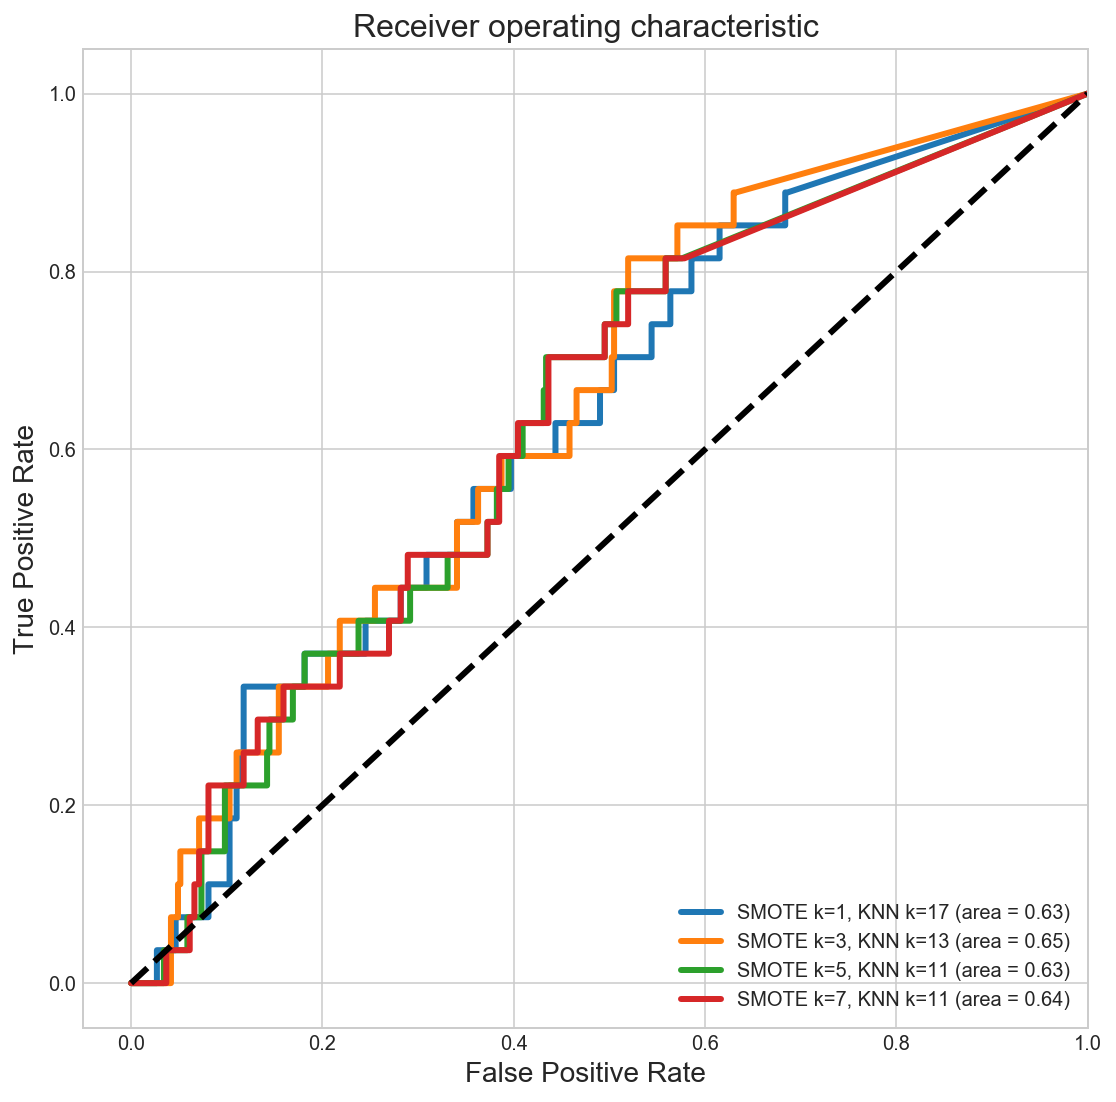

In [550]:
# gridsearch

# initialise
plt.figure(figsize=[9,9])
k_values = range(1, 8, 2) # choose max k_neighbors of 7, because only have 9 in minority class test set
scoring = 'roc_auc'

# loop over various values of k to use in SMOTE
for k in k_values:
    # perform sampling
    print 'SMOTE k=',k
    sampler = SMOTE(ratio='minority', random_state=rs, k_neighbors=k)
    cXs_train_sm, cy_train_sm = sampler.fit_sample(cXs_train, cy_train)
    print 'Ratio of training set:', cy_train_sm.mean()

    # use gridsearch to optimise KNN
    knn = KNeighborsClassifier()
    params = {
        'n_neighbors': range(1, 30, 2),
        'weights': ['uniform', 'distance'],
        'p': [1, 2] # 1= manhattan, 2=euclidean
    }

    knn_search = GridSearchCV(knn, params, n_jobs=njobs, cv=5, verbose=1, scoring=scoring)
    knn_search.fit(cXs_train_sm, cy_train_sm)
    best_knn = knn_search.best_estimator_
    print knn_search.best_params_

    # use model to predict y
    cy_pred = best_knn.predict(cXs_test)
    cy_prob = best_knn.predict_proba(cXs_test)

    # display confusion matrix & classification report
    print 'Confusion Matrix:'
    print confusion_matrix(cy_test, cy_pred)
    print classification_report(cy_test, cy_pred)

    # plot ROC curve
    fpr, tpr, _ = roc_curve(cy_test, cy_prob[:,1]) # y probabilities for label 1
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='SMOTE k={}, KNN k={} (area = {:0.2f})'.format(k,knn_search.best_params_['n_neighbors'], roc_auc), linewidth=3)

# make the plot pretty
plt.plot([0, 1], [0, 1], 'k--', linewidth=3)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver operating characteristic', fontsize=16)
plt.legend(loc="lower right")
plt.show()  

The best model is SMOTE with k=1, and KNN with k=17, weights=distance and p=1

#### Identify features that are most predictive of abnormal sales:

number of non-zero coefficients: 168 / 197


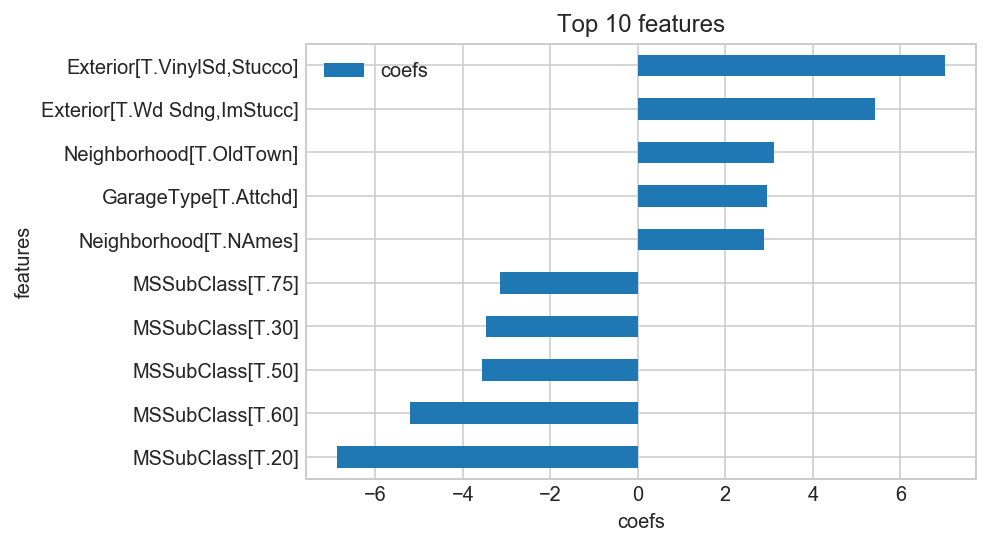

,features,coefs,abs_coefs
0,MSSubClass[T.160],-0.289465,0.289465
1,MSSubClass[T.180],-0.257830,0.257830
2,MSSubClass[T.190],-0.467370,0.467370
3,MSSubClass[T.20],-6.884545,6.884545
4,MSSubClass[T.30],-3.461747,3.461747
5,MSSubClass[T.40],-1.040541,1.040541
6,MSSubClass[T.45],-1.683703,1.683703
7,MSSubClass[T.50],-3.550872,3.550872
8,MSSubClass[T.60],-5.197986,5.197986
9,MSSubClass[T.70],-2.799077,2.799077


In [538]:
# use the coefficients from the logisitic regression with lasso that we ran earlier
# to determine which features to remove for further feature selection
coef_impt = feature_impt.loc[:,['Features', 'Logistic Regression with Lasso - SMOTE']]
coef_impt.columns=['features', 'coefs']
coef_impt['abs_coefs'] = np.abs(coef_impt.coefs)
coef_impt.sort_values('coefs', ascending=False)

# # put coefficients into a nice dataframe
#     var = pd.DataFrame({'coefs': classifier.coef_, 
#                         'abs_coefs': np.abs(classifier.coef_),
#                         'features': X.columns})

# Number of non-zero coefficients
print 'number of non-zero coefficients: {:d} / {:d}'.format((coef_impt.coefs!=0).sum(), coef_impt.shape[0])

# plot coefficients of the 10 best features
bestvars = coef_impt.sort_values('abs_coefs', ascending=False).head(10)
bestvars.sort_values('coefs').plot(kind='barh', x='features', y='coefs')
plt.xlabel('coefs')
plt.title('Top 10 features')
plt.show()

coef_impt

#### References:
- https://blog.dominodatalab.com/imbalanced-datasets/
- https://github.com/scikit-learn-contrib/imbalanced-learn
- https://beckernick.github.io/oversampling-modeling/
- https://www.youtube.com/watch?v=-Z1PaqYKC1w
- https://kevinzakka.github.io/2016/07/13/k-nearest-neighbor/#parameter-tuning-with-cross-validation

SMOTEENN:
http://contrib.scikit-learn.org/imbalanced-learn/stable/combine.html#combine

SMOTE: 
- http://contrib.scikit-learn.org/imbalanced-learn/stable/generated/imblearn.over_sampling.SMOTE.html
- http://contrib.scikit-learn.org/imbalanced-learn/stable/over_sampling.html#smote-adasyn

ENN: 
- http://contrib.scikit-learn.org/imbalanced-learn/stable/generated/imblearn.under_sampling.EditedNearestNeighbours.html
- http://contrib.scikit-learn.org/imbalanced-learn/stable/under_sampling.html#edited-nearest-neighbors